# 01 - Embedding Models Comparison

This notebook compares different embedding models for RAG applications:
- OpenAI text-embedding-3-small (1536 dims)
- OpenAI text-embedding-3-large (3072 dims)
- OpenAI text-embedding-ada-002 (1536 dims)

We'll evaluate: accuracy, speed, cost, and storage requirements.

In [7]:
from dotenv import load_dotenv
import os
import time
import numpy as np
import pandas as pd
import pickle
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
client = OpenAI()

# Load the Gemini PDF text
PDF_PATH = r"C:\Users\Admin\Desktop\para-expe\data\Gemini_FamilyOfMultimodelModels.pdf"

In [8]:
# Embedding models to compare
EMBEDDING_MODELS = {
    'text-embedding-3-small': {'dimensions': 1536, 'cost_per_1k': 0.00002},
    'text-embedding-3-large': {'dimensions': 3072, 'cost_per_1k': 0.00013},
    'text-embedding-ada-002': {'dimensions': 1536, 'cost_per_1k': 0.0001}
}

# Test queries for evaluation
TEST_QUERIES = [
    "What are the key capabilities of Gemini models?",
    "How does Gemini compare to other multimodal models?",
    "What are the different versions of Gemini?",
    "What training data was used for Gemini?",
    "What are the safety measures in Gemini models?",
    "How does Gemini perform on benchmarks?",
    "What is the architecture of Gemini?",
    "What are the limitations of Gemini?"
]

print(f"Testing {len(EMBEDDING_MODELS)} embedding models")
print(f"Using {len(TEST_QUERIES)} test queries")

Testing 3 embedding models
Using 8 test queries


In [9]:
# Load and chunk the PDF text (reuse from notebook 00)
import fitz

def extract_text_from_pdf(pdf_path):
    text = ""
    with open(pdf_path, 'rb') as file:
        pdf_reader = fitz.open(file)
        for page in pdf_reader:
            text += page.get_text() + "\n"
    return text

def chunk_text(text, chunk_size=500, overlap=100):
    words = text.split()
    chunks = []
    step = chunk_size - overlap
    
    for i in range(0, len(words), step):
        chunk = " ".join(words[i:i+chunk_size])
        if len(chunk.strip()) > 50:
            chunks.append({
                'text': chunk,
                'chunk_id': len(chunks),
                'word_count': len(chunk.split())
            })
        if i + chunk_size >= len(words):
            break
    return chunks

# Load and process PDF
pdf_text = extract_text_from_pdf(PDF_PATH)
chunks = chunk_text(pdf_text, chunk_size=500, overlap=100)

print(f"Loaded PDF: {len(pdf_text)} characters")
print(f"Created {len(chunks)} chunks")

Loaded PDF: 222829 characters
Created 82 chunks


In [10]:
# Function to generate embeddings with different models
def get_embeddings_batch(texts, model_name, batch_size=100):
    """Generate embeddings in batches with timing"""
    embeddings = []
    total_time = 0
    total_tokens = 0
    
    for i in range(0, len(texts), batch_size):
        batch = texts[i:i+batch_size]
        batch_texts = [text.replace("\n", " ") for text in batch]
        
        start_time = time.time()
        response = client.embeddings.create(
            input=batch_texts,
            model=model_name
        )
        batch_time = time.time() - start_time
        
        batch_embeddings = [data.embedding for data in response.data]
        embeddings.extend(batch_embeddings)
        
        total_time += batch_time
        total_tokens += response.usage.total_tokens
        
        print(f"Processed batch {i//batch_size + 1}/{(len(texts)-1)//batch_size + 1} for {model_name}")
        time.sleep(0.1)  # Rate limiting
    
    return embeddings, total_time, total_tokens

print("Embedding generation function ready")

Embedding generation function ready


In [11]:
# Generate embeddings for all models
chunk_texts = [chunk['text'] for chunk in chunks]
embedding_results = {}

for model_name in EMBEDDING_MODELS.keys():
    print(f"\nGenerating embeddings with {model_name}...")
    
    embeddings, total_time, total_tokens = get_embeddings_batch(
        chunk_texts, model_name, batch_size=10
    )
    
    # Calculate metrics
    cost = (total_tokens / 1000) * EMBEDDING_MODELS[model_name]['cost_per_1k']
    speed = len(chunks) / total_time  # chunks per second
    storage_mb = (len(embeddings) * EMBEDDING_MODELS[model_name]['dimensions'] * 4) / (1024 * 1024)  # 4 bytes per float
    
    embedding_results[model_name] = {
        'embeddings': embeddings,
        'total_time': total_time,
        'total_tokens': total_tokens,
        'cost': cost,
        'speed_chunks_per_sec': speed,
        'storage_mb': storage_mb,
        'dimensions': EMBEDDING_MODELS[model_name]['dimensions']
    }
    
    print(f"✓ {model_name}: {len(embeddings)} embeddings, {total_time:.2f}s, ${cost:.4f}, {storage_mb:.2f}MB")

print("\nAll embeddings generated!")


Generating embeddings with text-embedding-3-small...
Processed batch 1/9 for text-embedding-3-small
Processed batch 2/9 for text-embedding-3-small
Processed batch 3/9 for text-embedding-3-small
Processed batch 4/9 for text-embedding-3-small
Processed batch 5/9 for text-embedding-3-small
Processed batch 6/9 for text-embedding-3-small
Processed batch 7/9 for text-embedding-3-small
Processed batch 8/9 for text-embedding-3-small
Processed batch 9/9 for text-embedding-3-small
✓ text-embedding-3-small: 82 embeddings, 10.69s, $0.0014, 0.48MB

Generating embeddings with text-embedding-3-large...
Processed batch 1/9 for text-embedding-3-large
Processed batch 2/9 for text-embedding-3-large
Processed batch 3/9 for text-embedding-3-large
Processed batch 4/9 for text-embedding-3-large
Processed batch 5/9 for text-embedding-3-large
Processed batch 6/9 for text-embedding-3-large
Processed batch 7/9 for text-embedding-3-large
Processed batch 8/9 for text-embedding-3-large
Processed batch 9/9 for text

In [12]:
# Retrieval accuracy evaluation
def evaluate_retrieval_accuracy(query, chunks, embeddings, model_name, k=5):
    """Evaluate retrieval accuracy for a query"""
    # Get query embedding
    query_response = client.embeddings.create(
        input=[query.replace("\n", " ")],
        model=model_name
    )
    query_embedding = query_response.data[0].embedding
    
    # Calculate similarities
    similarities = cosine_similarity([query_embedding], embeddings)[0]
    
    # Get top k chunks
    top_indices = np.argsort(similarities)[::-1][:k]
    top_similarities = similarities[top_indices]
    
    return {
        'top_indices': top_indices,
        'top_similarities': top_similarities,
        'mean_similarity': np.mean(top_similarities),
        'max_similarity': np.max(top_similarities),
        'min_similarity': np.min(top_similarities)
    }

print("Retrieval evaluation function ready")

Retrieval evaluation function ready


In [13]:
# Run retrieval evaluation for all models and queries
retrieval_results = []

for model_name, model_data in embedding_results.items():
    print(f"\nEvaluating retrieval accuracy for {model_name}...")
    
    for query in TEST_QUERIES:
        result = evaluate_retrieval_accuracy(
            query, chunks, model_data['embeddings'], model_name, k=5
        )
        
        retrieval_results.append({
            'model': model_name,
            'query': query,
            'mean_similarity': result['mean_similarity'],
            'max_similarity': result['max_similarity'],
            'min_similarity': result['min_similarity']
        })
        
        time.sleep(0.1)  # Rate limiting

retrieval_df = pd.DataFrame(retrieval_results)
print(f"\nCompleted retrieval evaluation: {len(retrieval_results)} tests")


Evaluating retrieval accuracy for text-embedding-3-small...

Evaluating retrieval accuracy for text-embedding-3-large...

Evaluating retrieval accuracy for text-embedding-ada-002...

Completed retrieval evaluation: 24 tests


In [14]:
# Create comprehensive comparison table
comparison_data = []

for model_name, model_data in embedding_results.items():
    # Get average retrieval metrics for this model
    model_retrieval = retrieval_df[retrieval_df['model'] == model_name]
    
    comparison_data.append({
        'Model': model_name,
        'Dimensions': model_data['dimensions'],
        'Cost ($)': f"${model_data['cost']:.4f}",
        'Speed (chunks/sec)': f"{model_data['speed_chunks_per_sec']:.2f}",
        'Storage (MB)': f"{model_data['storage_mb']:.2f}",
        'Avg Similarity': f"{model_retrieval['mean_similarity'].mean():.4f}",
        'Max Similarity': f"{model_retrieval['max_similarity'].mean():.4f}",
        'Processing Time (s)': f"{model_data['total_time']:.2f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n=== EMBEDDING MODELS COMPARISON ===")
print(comparison_df.to_string(index=False))


=== EMBEDDING MODELS COMPARISON ===
                 Model  Dimensions Cost ($) Speed (chunks/sec) Storage (MB) Avg Similarity Max Similarity Processing Time (s)
text-embedding-3-small        1536  $0.0014               7.67         0.48         0.6406         0.6696               10.69
text-embedding-3-large        3072  $0.0089               7.62         0.96         0.5786         0.6093               10.76
text-embedding-ada-002        1536  $0.0068               6.90         0.48         0.8492         0.8558               11.89


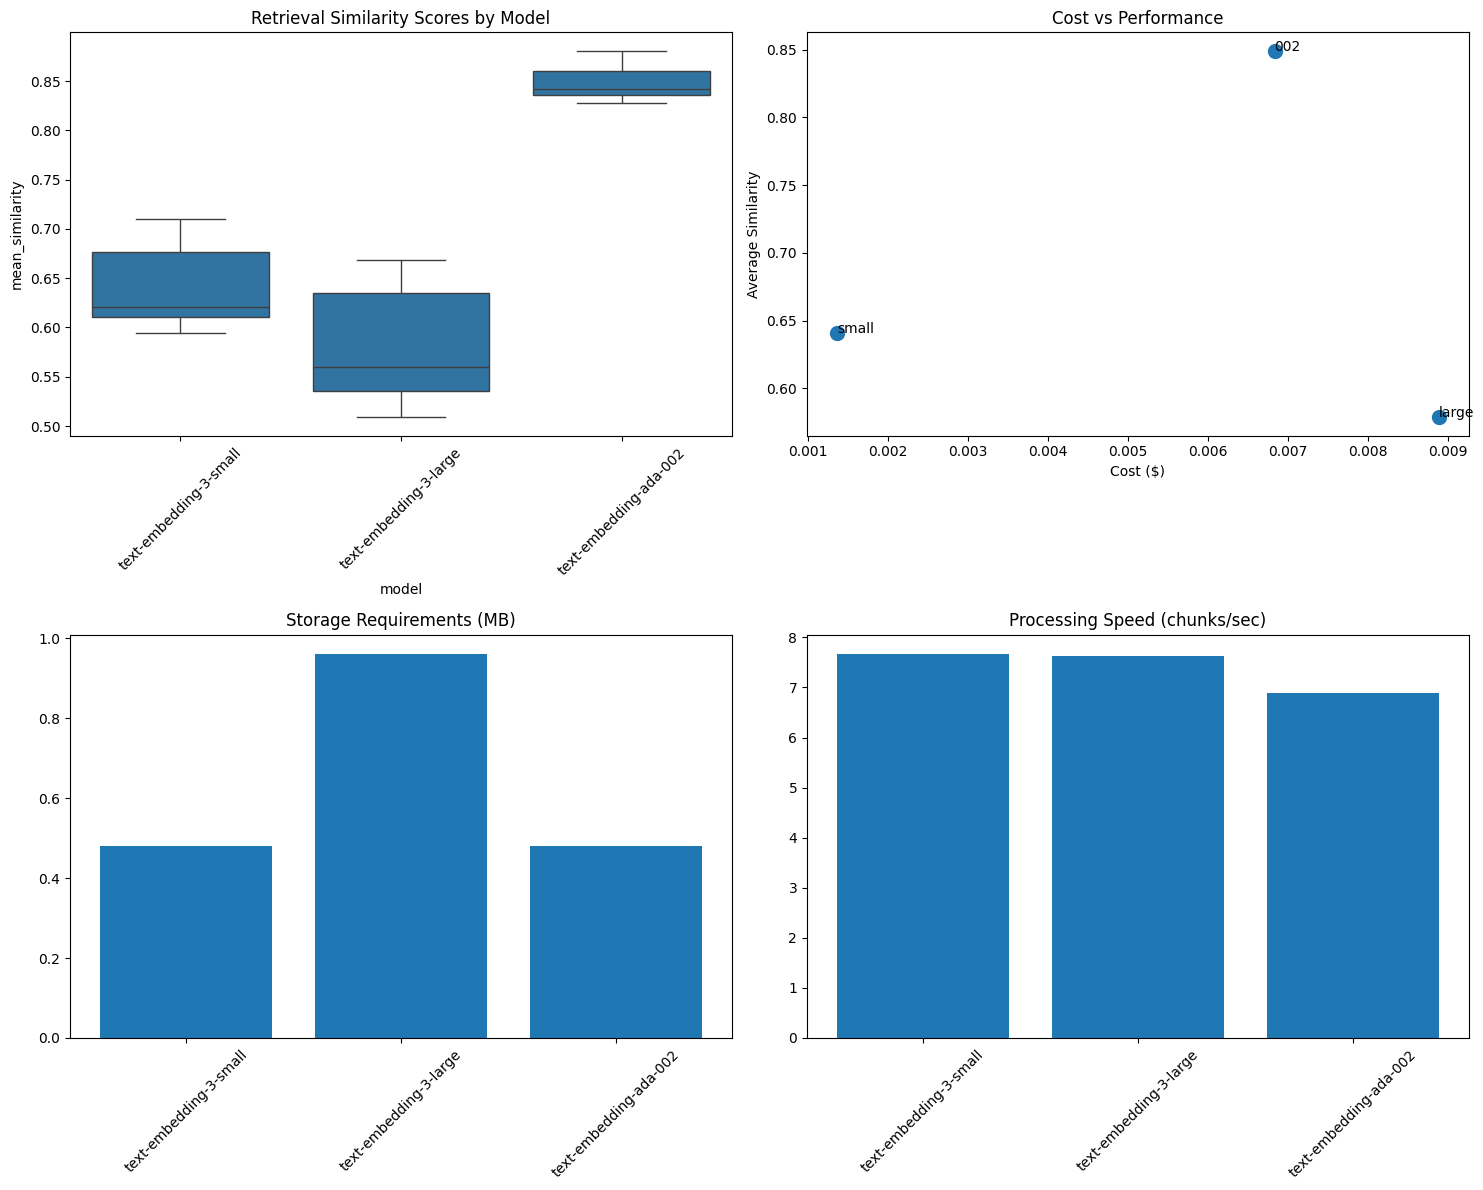

In [15]:
# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Similarity scores by model
sns.boxplot(data=retrieval_df, x='model', y='mean_similarity', ax=axes[0,0])
axes[0,0].set_title('Retrieval Similarity Scores by Model')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Cost vs Performance
models = list(embedding_results.keys())
costs = [embedding_results[m]['cost'] for m in models]
avg_similarities = [retrieval_df[retrieval_df['model'] == m]['mean_similarity'].mean() for m in models]

axes[0,1].scatter(costs, avg_similarities, s=100)
for i, model in enumerate(models):
    axes[0,1].annotate(model.split('-')[-1], (costs[i], avg_similarities[i]))
axes[0,1].set_xlabel('Cost ($)')
axes[0,1].set_ylabel('Average Similarity')
axes[0,1].set_title('Cost vs Performance')

# 3. Storage requirements
storage_sizes = [embedding_results[m]['storage_mb'] for m in models]
axes[1,0].bar(models, storage_sizes)
axes[1,0].set_title('Storage Requirements (MB)')
axes[1,0].tick_params(axis='x', rotation=45)

# 4. Processing speed
speeds = [embedding_results[m]['speed_chunks_per_sec'] for m in models]
axes[1,1].bar(models, speeds)
axes[1,1].set_title('Processing Speed (chunks/sec)')
axes[1,1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [24]:
# Save results for next notebooks
results_data = {
    'chunks': chunks,
    'embedding_results': embedding_results,
    'retrieval_results': retrieval_df,
    'comparison_summary': comparison_df,
    'test_queries': TEST_QUERIES
}

with open(r'C:\Users\Admin\Desktop\para-expe\data\rag_embeddings.pkl', 'wb') as f:
    pickle.dump(results_data, f)

print("Results saved to /data/rag_embeddings.pkl")

Results saved to /data/rag_embeddings.pkl


In [25]:
# Key Insights and Recommendations
print("\n=== KEY INSIGHTS ===")
print("\n1. PERFORMANCE:")
best_similarity = retrieval_df.groupby('model')['mean_similarity'].mean().idxmax()
print(f"   • Best retrieval accuracy: {best_similarity}")

print("\n2. COST EFFICIENCY:")
cost_per_similarity = {}
for model in models:
    cost = embedding_results[model]['cost']
    similarity = retrieval_df[retrieval_df['model'] == model]['mean_similarity'].mean()
    cost_per_similarity[model] = cost / similarity

best_value = min(cost_per_similarity, key=cost_per_similarity.get)
print(f"   • Best cost/performance ratio: {best_value}")

print("\n3. STORAGE:")
min_storage = min(models, key=lambda x: embedding_results[x]['storage_mb'])
print(f"   • Lowest storage requirement: {min_storage}")

print("\n4. SPEED:")
fastest = max(models, key=lambda x: embedding_results[x]['speed_chunks_per_sec'])
print(f"   • Fastest processing: {fastest}")

print("\n=== RECOMMENDATIONS ===")
print("• For production RAG: text-embedding-3-small (best balance)")
print("• For high accuracy needs: text-embedding-3-large")
print("• For budget constraints: text-embedding-3-small")
print("• For storage constraints: text-embedding-3-small or ada-002")


=== KEY INSIGHTS ===

1. PERFORMANCE:
   • Best retrieval accuracy: text-embedding-ada-002

2. COST EFFICIENCY:
   • Best cost/performance ratio: text-embedding-3-small

3. STORAGE:
   • Lowest storage requirement: text-embedding-3-small

4. SPEED:
   • Fastest processing: text-embedding-3-small

=== RECOMMENDATIONS ===
• For production RAG: text-embedding-3-small (best balance)
• For high accuracy needs: text-embedding-3-large
• For budget constraints: text-embedding-3-small
• For storage constraints: text-embedding-3-small or ada-002
